#  Cartpole with Policy Gradient method: REINFORCE


REINFORE implements a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$

The goal is to *maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*. 



### REINFORCE algorithm with a NN as a policy approximation method:


FOR number of episodes:  

    1. Act on the current policy for a single episode and collect state / action / reward triplets.
    2. Calculate the discounted rewards of the episode.
    3. Calculate the loss of all the actions and backpropagate the gradient to improve the policy.
    
When acting on the policy, in order to balace the exploration - exploitation trade-off, the action will be <u>sampled</u> .

In order to compare with other approaches on the same environment, the training procedure will be stopped when the average reward of the last 100 episodes is greater than 195. ( out of the 200 maximum )

### The goal of this notebook is not to solve cartpole as efficiently as possible, but to experiment and have fun.

In [15]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from gym import wrappers

#### The environment

In [2]:

env = gym.make('CartPole-v0') # Create environment
s = env.reset()
a = env.action_space.sample()
print(s.shape)
print('sample state:', s)
print('sample action:', a )

(4,)
sample state: [-0.0226606  -0.03983343 -0.01674916  0.00842222]
sample action: 1


##### Function to visualize cartpole in jupyter
ref: https://kyso.io/eoin/openai-gym-jupyter

In [88]:
def show_replay():
    """
    Not-so-elegant way to display the MP4 file generated by the Monitor wrapper inside a notebook.
    The Monitor wrapper dumps the replay to a local file that we then display as a HTML video object.
    """
    import io
    import base64
    video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''
        <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
    .format(encoded.decode('ascii')))

In [5]:
env = gym.make('CartPole-v0') # Create environment
env = wrappers.Monitor(env, "./gym-results", force=True) # Create wrapper to display environment
env.reset() # Reset environment

# Run environment
while True:
    env.render() # Render environment
    action = env.action_space.sample() # Get a random action
    _, _, done, _ = env.step(action) # Take a step
    if done: break # Break if environment is done

env.close() # Close environment
show_replay()


### Policy approximation Neural network

In [75]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden,n_hidden2, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden = nn.Linear(n_inputs, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden2)
        self.out = nn.Linear(n_hidden2, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))
    
    def backpropagate_loss(self,a_probs,returns):
        
        loss = self.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        


### Running a single episode and collecting stats

In [76]:
# run a training episode, act by sampling from policy in order to explore.
def run_training_episode(policy,env):
    
    rollout = []
    s = env.reset()
    done = False
    with torch.no_grad():

        while not done:

            a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
            a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
            s1, r, done, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
        
    # prepare episoded stats
    rollout = np.array(rollout)
    states = np.vstack(rollout[:,0])
    actions = np.vstack(rollout[:,1])
    rewards = np.array(rollout[:,2], dtype=float)
    
    return states, actions, rewards

# run a validation episode, act greedily on the policy by selecting the most promising action.
def run_validation_episode(policy,env,val_freq):
    
    validation_rewards = []
    for _ in range(val_freq):
        s = env.reset()
        reward = 0
        done = False
        
        with torch.no_grad():

            while not done:
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                a = a_prob.argmax().item()
                s, r, done, _ = env.step(a)
                reward += r
                if done: break
                    
        validation_rewards.append(reward)
    
    return validation_rewards

### Compute discounted returns

In [77]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

# REINFORCE

In [86]:
# number of runs, to compute average episode length until learning is considered done
runs = 10
average_episodes = []

#overall bookeeping lists:
overall_training_rewards, overall_validation_rewards = [], []

# training settings
n_inputs = env.observation_space.shape[0]
n_hidden = 32
n_hidden2 = 16
n_outputs = env.action_space.n

discount_factor = 0.99 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency

#training procedure:
for run in range(runs):
    
    # setup policy network
    policy = PolicyNet(n_inputs, n_hidden, n_hidden2, n_outputs, learning_rate)

    # bookeeping lists
    training_rewards, validation_rewards, episode_counter = [], [], 0
    while True:

        # 1. 
        states, actions, rewards  = run_training_episode(policy,env)

        # 2.
        returns = compute_returns(rewards, discount_factor)

        # 3.
        policy.optimizer.zero_grad()
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
        policy.backpropagate_loss(a_probs,returns)

        # bookkeeping
        training_rewards.append(sum(rewards))

        # Validate policy and update output.
        if (episode_counter+1) % val_freq == 0:
            validation_rewards += run_validation_episode(policy,env,val_freq)
            #print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}'.format(episode_counter+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards[-val_freq:])))
        
        # Increment episode counter
        episode_counter+=1
        
        # Stop if running average reward is greater than 195
        if np.mean(training_rewards[-val_freq:]) >= 195: break
    
    print("Run "+str(run)+" finished after "+str(episode_counter)+" episodes.")
    average_episodes.append(episode_counter)
    overall_training_rewards.append(training_rewards)
    overall_validation_rewards.append(validation_rewards)

print("Average number of steps needed for the algorithm to learn: "+str(int(np.mean(average_episodes))))

<ipython-input-76-70f35df9d679>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rollout = np.array(rollout)


Run 0 finished after 1807 episodes.
Run 1 finished after 1963 episodes.
Run 2 finished after 2268 episodes.
Run 3 finished after 1073 episodes.
Run 4 finished after 1253 episodes.
Run 5 finished after 1733 episodes.
Run 6 finished after 2123 episodes.
Run 7 finished after 1297 episodes.
Run 8 finished after 1055 episodes.
Run 9 finished after 1645 episodes.
Average number of steps needed for the algorithm to learn: 1621


## Visualizing average Rewards and cartpole`s behaviour.

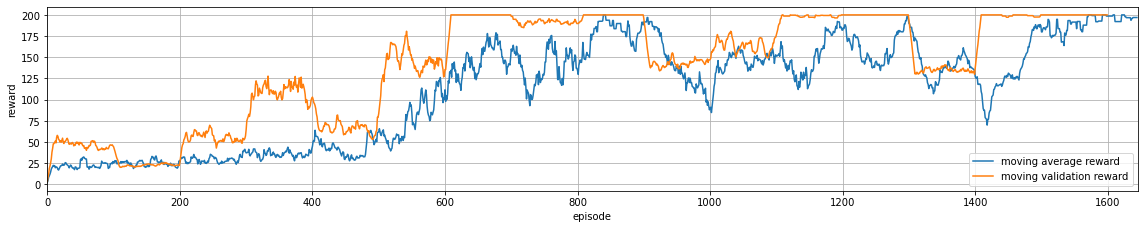

In [87]:
# Plotting trianing and validation rewards over time for the last run.

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(moving_average(training_rewards),label='moving average reward')
plt.plot(moving_average(validation_rewards),label='moving validation reward')
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

The goal in RL is to select a policy which maximizes expected return when the agent acts according to it.
As it can be seen in the graph, after a period of training it is optimal to greedily act on the policy.


In [89]:
env = wrappers.Monitor(env, "./gym-results", force=True) # Create wrapper to display environment
s = env.reset()

for _ in range(500):
    env.render()
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _ = env.step(a)
    if done: break
    
env.close()
show_replay()

## Possible extensions:

By default, Monte carlo control has high variance ( as it can be seen in the average reward plots ) and therefore variance reduction can enhance the training procedure.

It is possible to reduce variance by subtracting a pre-computed baseline from the returns.  


Ref:https://www.endtoend.ai/blog/bias-variance-tradeoff-in-reinforcement-learning/